# Willman 1: Membership criteria

Import necessary packages

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None # overwriting values in df without warnings
pd.set_option('display.max_columns', None) # display whole table in line
pd.set_option('display.max_rows', None)

import numpy as np
import astropy
from astropy.table import Table

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import membership_utils
import wil1_properties
from wil1_properties import ra_w1, dec_w1, r_half, alpha, aax, ecc, bax, dist

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# some code for prettier plots
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12,
                     'axes.labelsize': 16,
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6),
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.major.size': 8,
                     'ytick.major.size': 8,
                     'xtick.minor.size': 4,
                     'ytick.minor.size': 4})

Open reduced data

In [3]:
# open data as astropy table
data_astropytable = Table.read("data/dmost_alldata_20260206_W1.fits")

# convert to pandas df
deimos_full = data_astropytable.to_pandas()

# compute delta ra with cos dec correction, delta dec
deimos_full["delta_ra_cosdec"] = (deimos_full["RA"] - ra_w1) * np.cos(np.deg2rad(dec_w1))
deimos_full["delta_dec"] = (deimos_full["DEC"] - dec_w1)

## Data overview

In [4]:
# general overview
mag_mask = (deimos_full["rmag_o"] != -999.)
ser_mask = (deimos_full["serendip"] == 1)
vel_mask = (deimos_full["v"] != -999.)
gal_mask = (deimos_full["marz_flag"] < 2)
ver_mask = (deimos_full["v_err"] < 15)

print("Total rows:                                    {}".format(len(deimos_full)))
print("All sources with photometry:                   {}".format(len(deimos_full[mag_mask])))
print("Unique targets with extracted DEIMOS spectra:  {}".format(len(deimos_full[mag_mask & ~ser_mask])))
print("All serendips sources with phot:               {}".format(len(deimos_full[mag_mask & ser_mask])))
print("All serendips sources with phot + v:           {}".format(len(deimos_full[mag_mask & ser_mask & vel_mask])))
print("All sources with phot + v:                     {}".format(len(deimos_full[mag_mask & vel_mask])))
print("All extragalactic:                             {}".format(len(deimos_full[mag_mask & vel_mask & ~gal_mask])))
print("Quasars:                                       {}".format(len(deimos_full[deimos_full["marz_flag"] == 6])))
print("All galactic sources + phot + v:               {}".format(len(deimos_full[mag_mask & vel_mask & gal_mask])))
print("Sources who do not pass velocity quality cut:  {} \n".format(len(deimos_full[mag_mask & vel_mask & gal_mask & ~ver_mask])))

# data used for membership selection (phot + vel + galactic + small vel err)
deimos_data = deimos_full[mag_mask & vel_mask & gal_mask & ver_mask]
print("Sources considered for membership:             {}".format(len(deimos_data)))

Total rows:                                    519
All sources with photometry:                   502
Unique targets with extracted DEIMOS spectra:  474
All serendips sources with phot:               28
All serendips sources with phot + v:           16
All sources with phot + v:                     340
All extragalactic:                             125
Quasars:                                       14
All galactic sources + phot + v:               215
Sources who do not pass velocity quality cut:  12 

Sources considered for membership:             203


In [7]:
# variable velocities (out of sources considered for membership)
measuredvariable_mask = (deimos_full["flag_var"] >= 0)
year_mask = (deimos_full["var_max_t"] >= 365)
variable_mask = (deimos_full["flag_var"] == 1)

print("Multiple velocity epochs:                      {}".format(len(deimos_full[measuredvariable_mask])))
print("Velocity epochs separated by >1 year:          {}".format(len(deimos_full[year_mask])))
print("Variable velocities:                           {} \n".format(len(deimos_full[variable_mask])))

# crosscheck with Gaia variable flag
cross_deimos_gaia = (deimos_full["flag_var"] == 1) & (deimos_full["gaia_phot_variable_flag"] == b'NOT')
cross_gaia_deimos = (deimos_full["flag_var"] == 0) & (deimos_full["gaia_phot_variable_flag"] == b'VAR')

print("Deimos variable + Gaia non-variable:           {}".format(len(deimos_full[cross_deimos_gaia])))
    # note all non-members based on CMD position
print("Deimos non-variable + Gaia variable:           {}".format(len(deimos_full[cross_gaia_deimos])))

Multiple velocity epochs:                      63
Velocity epochs separated by >1 year:          63
Variable velocities:                           16 

Deimos variable + Gaia non-variable:           6
Deimos non-variable + Gaia variable:           0


In [8]:
# gaia overview
gaia_mask1 = (deimos_full["gaia_pmra_err"] > 0)
gaia_mask2 = ((deimos_data["gaia_pmra_err"] > 0) & 
              (((deimos_data["gaia_pmra_err"] / deimos_data["gaia_pmra"]) < 2) & 
               ((deimos_data["gaia_pmdec_err"] / deimos_data["gaia_pmdec"]) < 2)))

print("Total sources with Gaia data:                  {}".format(len(deimos_full[gaia_mask1])))
print("Sources considered for membership + Gaia data: {}".format(len(deimos_data[gaia_mask2])))

print("Galactic sources with Gaia + no Deimos vel:    {}".format(len(deimos_full[gaia_mask1 & gal_mask & ~vel_mask])))

Total sources with Gaia data:                  82
Sources considered for membership + Gaia data: 65
Galactic sources with Gaia + no Deimos vel:    3


## General properties

Define spatial area of W1 based on measurements from Munoz et al. (2018).

$$
e = \sqrt{1 - (n-1)^2} = \sqrt{\frac{a^2 - b^2}{a^2}}
$$

Determine spatial properties of stars considered for membership:

In [9]:
# empty columns
deimos_data["radius"]         = np.nan      # distance to center of Wil1 [deg]
deimos_data["radius_ell"]     = np.nan      # distance to center, calculated from elliptical radii [deg]
deimos_data["hl_radius_circ"] = np.nan      # distance to center of Wil1 [half-light radii]
deimos_data["hl_radius_ell"]  = np.nan      # half-light elliptical radius
deimos_data["r_proj"]         = np.nan      # projected half-light radius
deimos_data["pos_angle"]      = np.nan      # position angle (deg)

# calculate spatial properties for each star
for index, row in deimos_data.iterrows():
    radius, ell_radius, hl_radius_circular, hl_radius_elliptical, proj_distance, p_angle = \
        membership_utils.spatial_prop(row["delta_ra_cosdec"], row["delta_dec"], 0, 0, r_half, -alpha, aax, ecc)
    
    deimos_data.loc[index, "radius"]         = radius
    deimos_data.loc[index, "radius_ell"]     = ell_radius
    deimos_data.loc[index, "hl_radius_circ"] = hl_radius_circular
    deimos_data.loc[index, "hl_radius_ell"]  = hl_radius_elliptical
    deimos_data.loc[index, "r_proj"]         = proj_distance
    deimos_data.loc[index, "pos_angle"]      = p_angle

Spatial plot

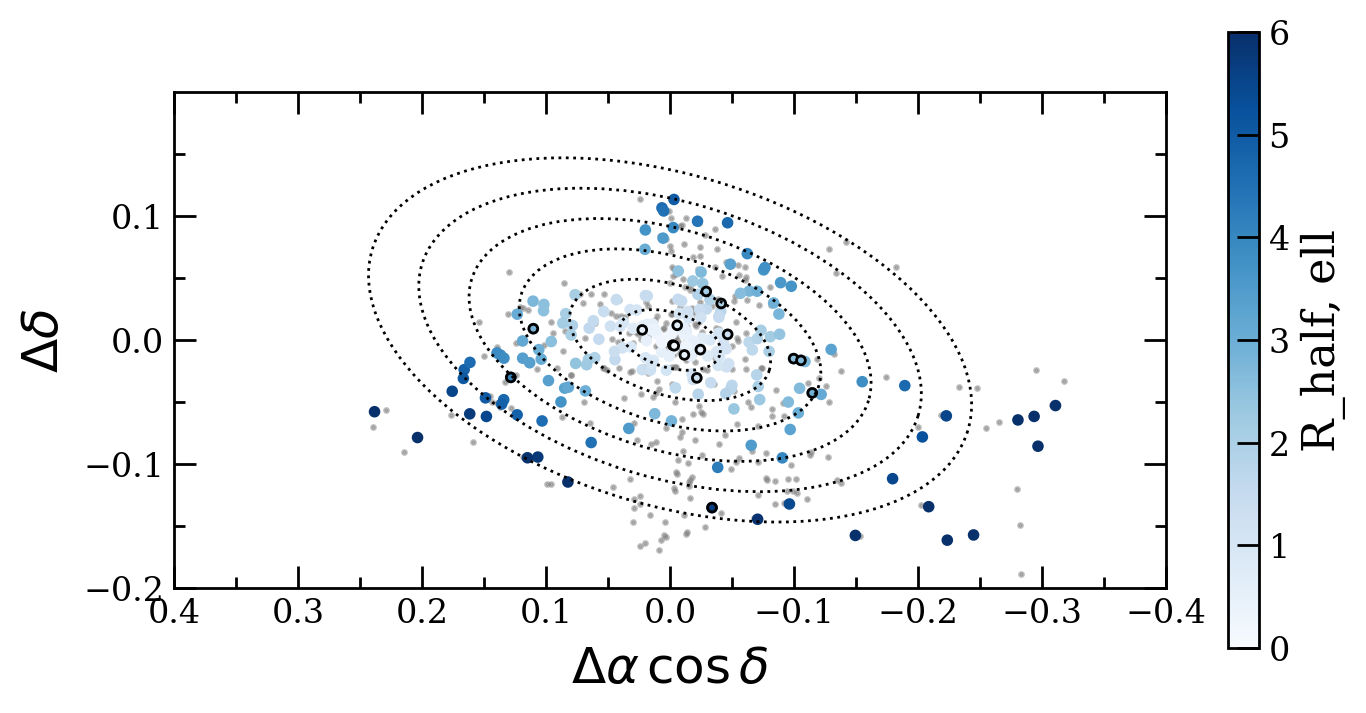

In [13]:
fig = plt.figure(figsize = (8, 4))
ax = fig.gca()
ax.set_aspect('equal', adjustable = 'box')

ax.scatter(deimos_full["delta_ra_cosdec"], deimos_full["delta_dec"], c = "grey", alpha = 0.5, s = 2)
data = ax.scatter(deimos_data["delta_ra_cosdec"], deimos_data["delta_dec"], c = deimos_data["hl_radius_ell"], 
                  cmap = "Blues", vmin = 0, vmax = 6, s = 10)
data = ax.scatter(deimos_data[deimos_data["flag_var"] == 1]["delta_ra_cosdec"], deimos_data[deimos_data["flag_var"] == 1]["delta_dec"], c = deimos_data[deimos_data["flag_var"] == 1]["hl_radius_ell"], 
                  cmap = "Blues", vmin = 0, vmax = 6, edgecolor = "black", s = 10)

for ii in range(6):
    jj = 2 * (ii + 1)
    ellipse = Ellipse((0, 0), bax * jj, aax * jj, angle = 360-73, fill = False, linestyle = ":", edgecolor = "black")
    ax.add_patch(ellipse)

ax.set_xlabel(r"$\Delta \alpha \, \cos \delta$", labelpad = 5, size = 18).set_color('black')
ax.set_ylabel(r"$\Delta \delta$", labelpad = 5, size = 18).set_color('black')

ax.set_xticks(np.arange(-0.5, 0.5, 0.1), minor = False)
ax.set_xticks(np.arange(-0.5, 0.5, 0.05), minor = True)
ax.tick_params(which = "major", axis = "x", direction = "in", size = 8, color = "black", top = True)
ax.tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax.set_yticks(np.arange(-0.2, 0.2, 0.1), minor = False)
ax.set_yticks(np.arange(-0.2, 0.2, 0.05), minor = True)
ax.tick_params(which = "major", axis = "y", direction = "in", size = 8, color = "black", right = True)
ax.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

ax.set_xlim(0.4, -0.4)
ax.set_ylim(-0.2, 0.2)

cbar = plt.colorbar(data, label = "R_half, ell")

# fig.savefig("deimos_spatial.pdf", dpi = 600, transparent = True)

## (1) CMD marker

Open isochrone data and convert to dataframe of values ($g-r$, $r$).

In [9]:
iso = astropy.io.ascii.read("data/isochrones/parsec_iso_feh_range.txt")
all_isos = iso.to_pandas()

all_isos["gr"] = np.asarray(all_isos["g'mag"] - iso["r'mag"])
all_isos["r"] = np.asarray(all_isos["r'mag"] + 5.*np.log10(dist * 1e3) - 5.)

all_isos = all_isos[all_isos["MH"] <= -1.9]
iso_data = all_isos[(all_isos["MH"] == -2.1) & (all_isos["logAge"] == 10.1)]
iso_gr = iso_data["gr"].values
iso_r  = iso_data["r"].values
iso_data = pd.concat([iso_data.iloc[0:113], iso_data.iloc[200:114:-1]], ignore_index = True)
iso_data.to_csv("data/isochrones/parsec_iso.csv")

/var/folders/3k/btgj6dcd6rgc2_bxvvn6172h0000gn/T/ipykernel_10333/2874895563.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(deimos_data["gmag_o"] - deimos_data["rmag_o"], deimos_data["rmag_o"], c = "red", alpha = 0.5,


(24.5, 14.0)

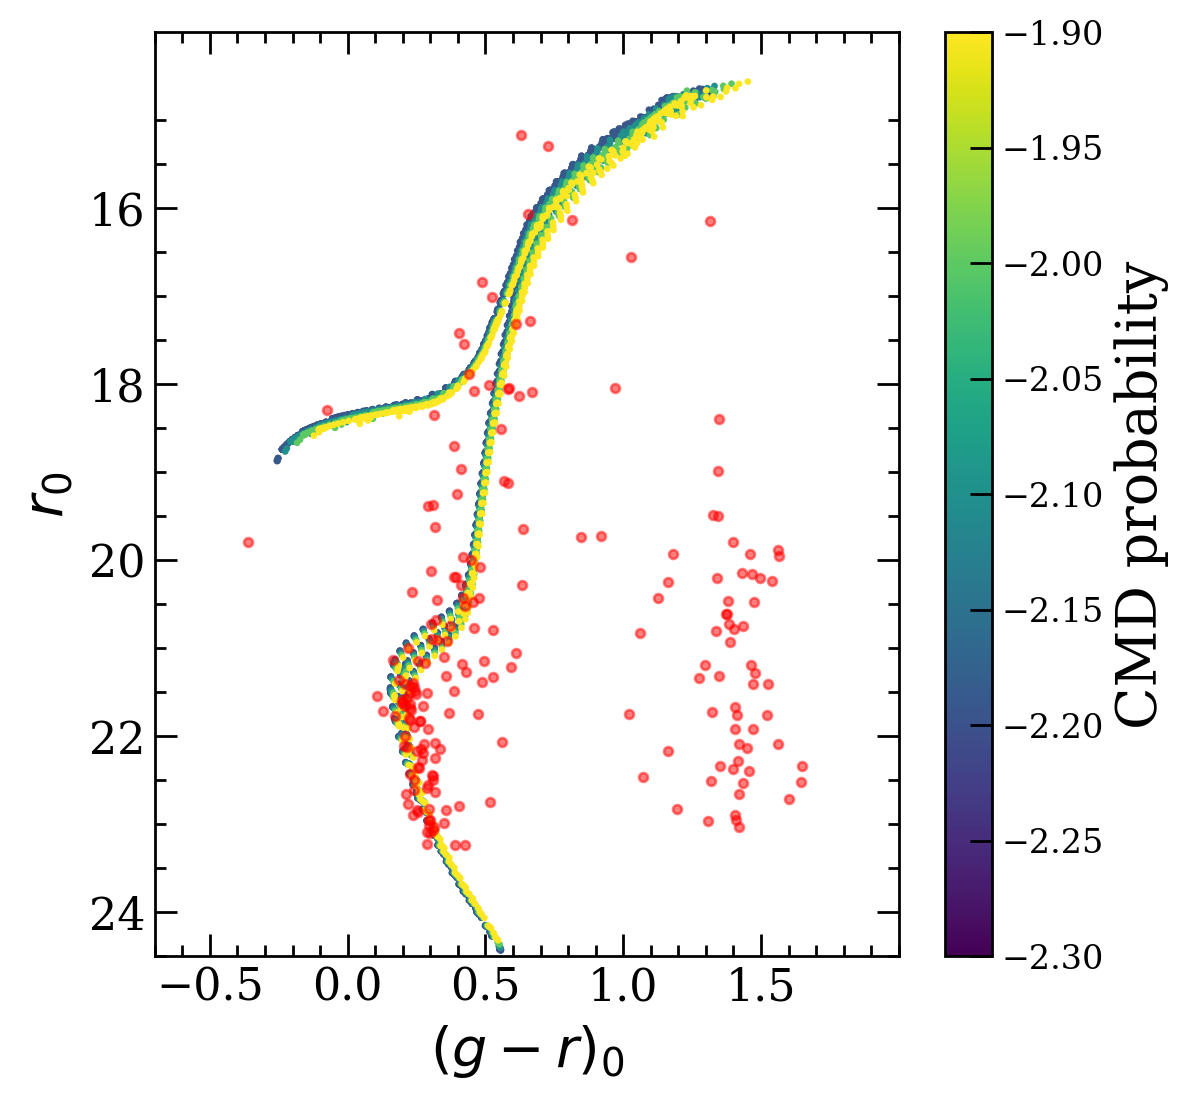

In [10]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# isochrone metallicity range
for ii in np.unique(all_isos["MH"]):
    iso_mh = all_isos[all_isos["MH"] == ii]
    data = ax.scatter(iso_mh["gr"], iso_mh["r"], c = iso_mh["MH"].values, cmap = "viridis", 
                  vmin = -2.3, vmax = -1.9, s = 2, zorder = 0)
    
# ax.plot(iso_gr, iso_r, c = "green", lw = 3, label = r"12 Gyr PARSEC isochrone, [Fe/H] = -2.1", zorder = 1)

# deimos full data
ax.scatter(deimos_data["gmag_o"] - deimos_data["rmag_o"], deimos_data["rmag_o"], c = "red", alpha = 0.5,
           s = 10, vmin = 0, vmax = 1, zorder = 2)

ax.set_xlabel("$(g-r)_0$", labelpad = 5, size = 20).set_color('black')
ax.set_ylabel("$r_0$", labelpad = 5, size = 20).set_color('black')

ax.set_xticks(np.arange(-0.5, 2, 0.5), minor = False)
ax.set_xticks(np.arange(-0.7, 2.1, 0.1), minor = True)
ax.tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 16, color = "black", top = True)
ax.tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax.set_yticks(np.arange(16, 26, 2), minor = False)
ax.set_yticks(np.arange(15, 25.5, 0.5), minor = True)
ax.tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 16, color = "black", right = True)
ax.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

cbar = plt.colorbar(data)
cbar.set_label("CMD probability", fontsize = 20)

ax.set_xlim(-0.7, 2)
ax.set_ylim(24.5, 14)

# fig.savefig("deimos_cmd.pdf", dpi = 600, transparent = True)

Define CMD probability distribution (modeled after Collins+2020):
$$
P_{\rm CMD} = \exp \Bigl( -\frac{d_{\perp}^2}{2 [\sigma_{CMD} ^2 + \delta_{mag}^2]} \Bigr)
$$

In [11]:
def prob_cmd(min_dist, data_sigma, iso_sigma):
    p_cmd = np.exp(-(min_dist ** 2) / (2 * (iso_sigma ** 2 + data_sigma ** 2)))
    return p_cmd

CMD marker

In [12]:
deimos_data["perp_dist_iso"] = np.nan         # perpendicular distance
deimos_data["cmd_marker"]    = np.nan         # cmd marker
deimos_data["prob_member"]   = np.nan         # overall membership probability

# calculate P_CMD for each star
for index_deimos, row_deimos in deimos_data.iterrows():
    # color, magnitude deimos data
    r_mag = deimos_data.loc[index_deimos, "rmag_o"]
    gr_mag = deimos_data.loc[index_deimos, "gmag_o"] - r_mag
    
    # add error data in quadrature
    r_mag_err = deimos_data.loc[index_deimos, "rmag_err"]
    g_mag_err = deimos_data.loc[index_deimos, "gmag_err"]
    gr_mag_err = (r_mag_err ** 2 + g_mag_err ** 2) ** (0.5)

    # calculate distance from star's cmd location to each point in isochrone
    iso_dists = np.sqrt((r_mag - iso_data["r"]) ** 2 + (gr_mag - iso_data["gr"])**2)
    d_min = np.min(iso_dists)
    deimos_data.loc[index_deimos, "perp_dist_iso"] = d_min

    # set isochrone error, to account for the metallicity spread + age uncertainty (estimated using grid of isochrones)
    iso_stdev = 0.15
    
    if d_min < 4 * iso_stdev: # calculate P_CMD from perpendicular distance
        prob = prob_cmd(d_min, gr_mag_err, iso_stdev)
        deimos_data.loc[index_deimos, "cmd_marker"] = prob
    
    else: # P_CMD = 0 if more than 4 * iso_stdev away from isochrone
        deimos_data.loc[index_deimos, "cmd_marker"] = 0
        deimos_data.loc[index_deimos, "prob_member"] = 0

Manually add in missing HB star, blue straggler so it's in plot

In [13]:
hb_index = deimos_data[(deimos_data["gmag_o"] - deimos_data["rmag_o"]) < -0].index.to_list()

deimos_data.loc[hb_index, "flag_HB"]     = True
deimos_data.loc[hb_index, "cmd_marker"]  = 0.9
deimos_data.loc[hb_index, "ew_feh"]      = -99.
deimos_data.loc[hb_index, "ew_feh_err"]  = -99.
deimos_data.loc[hb_index, "prob_member"] = np.nan

bs_index = deimos_data.index.to_list()[np.where(np.abs(deimos_data["RA"] - 162.175708) < 0.001)[0][0]] # blue straggler
deimos_data.loc[bs_index, "cmd_marker"] = 0.1
deimos_data.loc[bs_index, "prob_member"] = np.nan

/var/folders/3k/btgj6dcd6rgc2_bxvvn6172h0000gn/T/ipykernel_10333/138934053.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  deimos_data.loc[hb_index, "flag_HB"]     = True


CMD plot

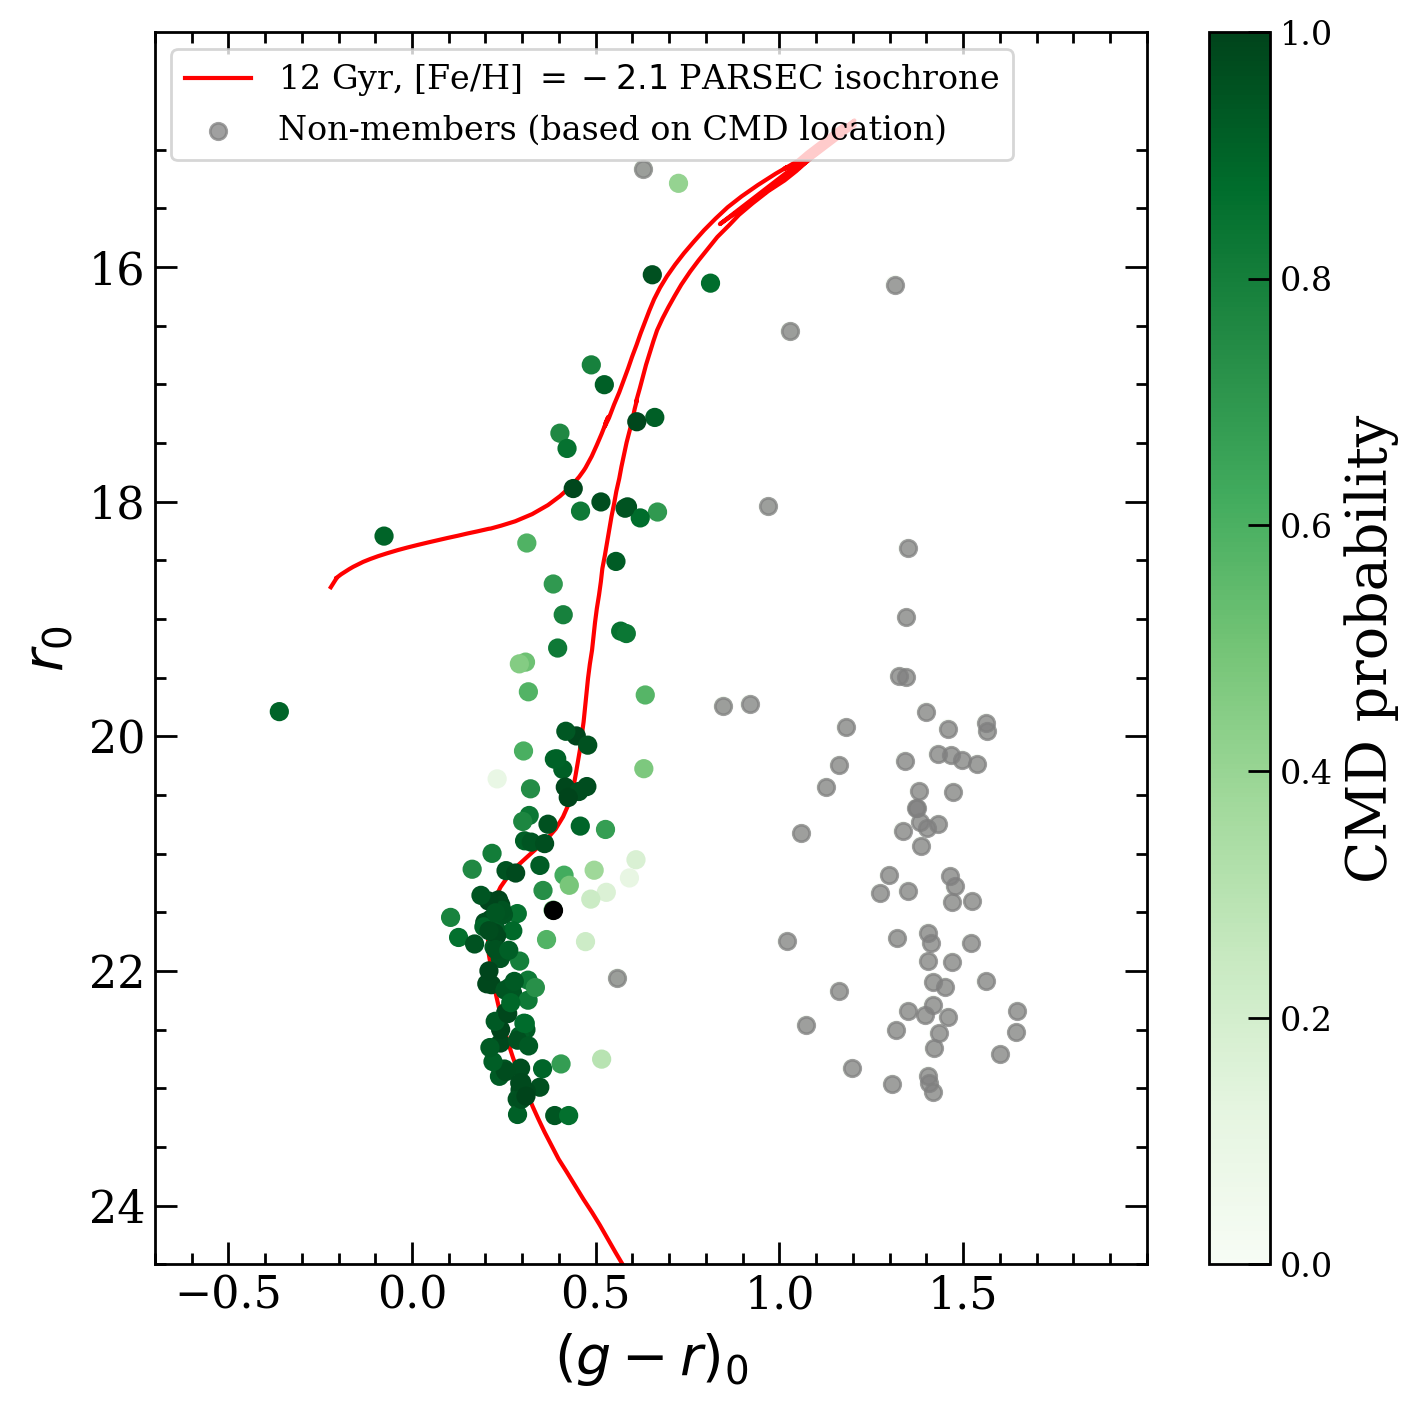

In [14]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

# isochrone
ax.plot(iso_data["gr"], iso_data["r"], c = "red", zorder = 0, label = r"12 Gyr, [Fe/H] $= -2.1$ PARSEC isochrone")

# deimos full data
data = ax.scatter(deimos_data["gmag_o"] - deimos_data["rmag_o"], deimos_data["rmag_o"], c = deimos_data["cmd_marker"], 
                  cmap = "Greens", s = 35, vmin = 0, vmax = 1, zorder = 2)

test = ax.scatter(deimos_data[np.abs(deimos_data["SN"] -  15.142439) < 0.01]["gmag_o"] - deimos_data[np.abs(deimos_data["SN"] -  15.142439) < 0.01]["rmag_o"], deimos_data[np.abs(deimos_data["SN"] -  15.142439) < 0.01]["rmag_o"], c = "black", zorder = 10, s = 35)

cmd_nonmember = deimos_data[deimos_data["cmd_marker"] < 0.1]
ax.scatter(cmd_nonmember["gmag_o"]-cmd_nonmember["rmag_o"], cmd_nonmember["rmag_o"], 
           c = "grey", alpha = 0.75, s = 35, zorder = 3, label = "Non-members (based on CMD location)")

ax.set_xlabel("$(g-r)_0$", labelpad = 5, size = 20).set_color('black')
ax.set_ylabel("$r_0$", labelpad = 5, size = 20).set_color('black')

ax.set_xticks(np.arange(-0.5, 2, 0.5), minor = False)
ax.set_xticks(np.arange(-0.7, 2.1, 0.1), minor = True)
ax.tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 16, color = "black", top = True)
ax.tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax.set_yticks(np.arange(16, 26, 2), minor = False)
ax.set_yticks(np.arange(15, 25.5, 0.5), minor = True)
ax.tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 16, color = "black", right = True)
ax.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

cbar = plt.colorbar(data)
cbar.set_label("CMD probability", fontsize = 20)

ax.set_xlim(-0.7, 2)
ax.set_ylim(24.5, 14)

ax.legend(loc = "upper left", fontsize = 12)

# fig.savefig("deimos_cmd.pdf", dpi = 600, transparent = True)

### (2) Velocity marker

Define velocity probability distribution:
$$
P_{\rm vel} = \exp \Bigl( -\frac{(v - v_{W1})^2}{2 [ (3\sigma_{v, W1})^2 + \delta_v^2 ]} \Bigr)
$$

In [15]:
def prob_vel(vel, v_err, v_avg, v_disp):
    p_vel = np.exp(-((vel - v_avg) ** 2) / (2 * ((3 * v_disp) ** 2 + v_err ** 2)))
    return p_vel

Determine P_vel

In [16]:
deimos_data["v_marker"] = np.nan  # empty column for velocity marker

v_avg2011, v_disp2011 = -12.8, 4.8        # previous estimate for systemic velocity, velocity dispersion (Willman+2011)
membership_utils.save_variable("v_avg2011", v_avg2011)
membership_utils.save_variable("v_disp2011", v_disp2011)

# calculate P_vel for each star
for index_deimos, row_deimos in deimos_data.iterrows():
    # velocity data
    vel = deimos_data.loc[index_deimos, "v"]
    v_err = deimos_data.loc[index_deimos, "v_err"]
    
    if (abs(vel) > 100): # P_vel = 0 if > 100 or <-100
        p_vel = 0
        deimos_data.loc[index_deimos, "prob_member"] = 0
    
    else:
        p_vel = prob_vel(vel, v_err, v_avg2011, v_disp2011)
    
    deimos_data.loc[index_deimos, "v_marker"] = p_vel

Velocity plot

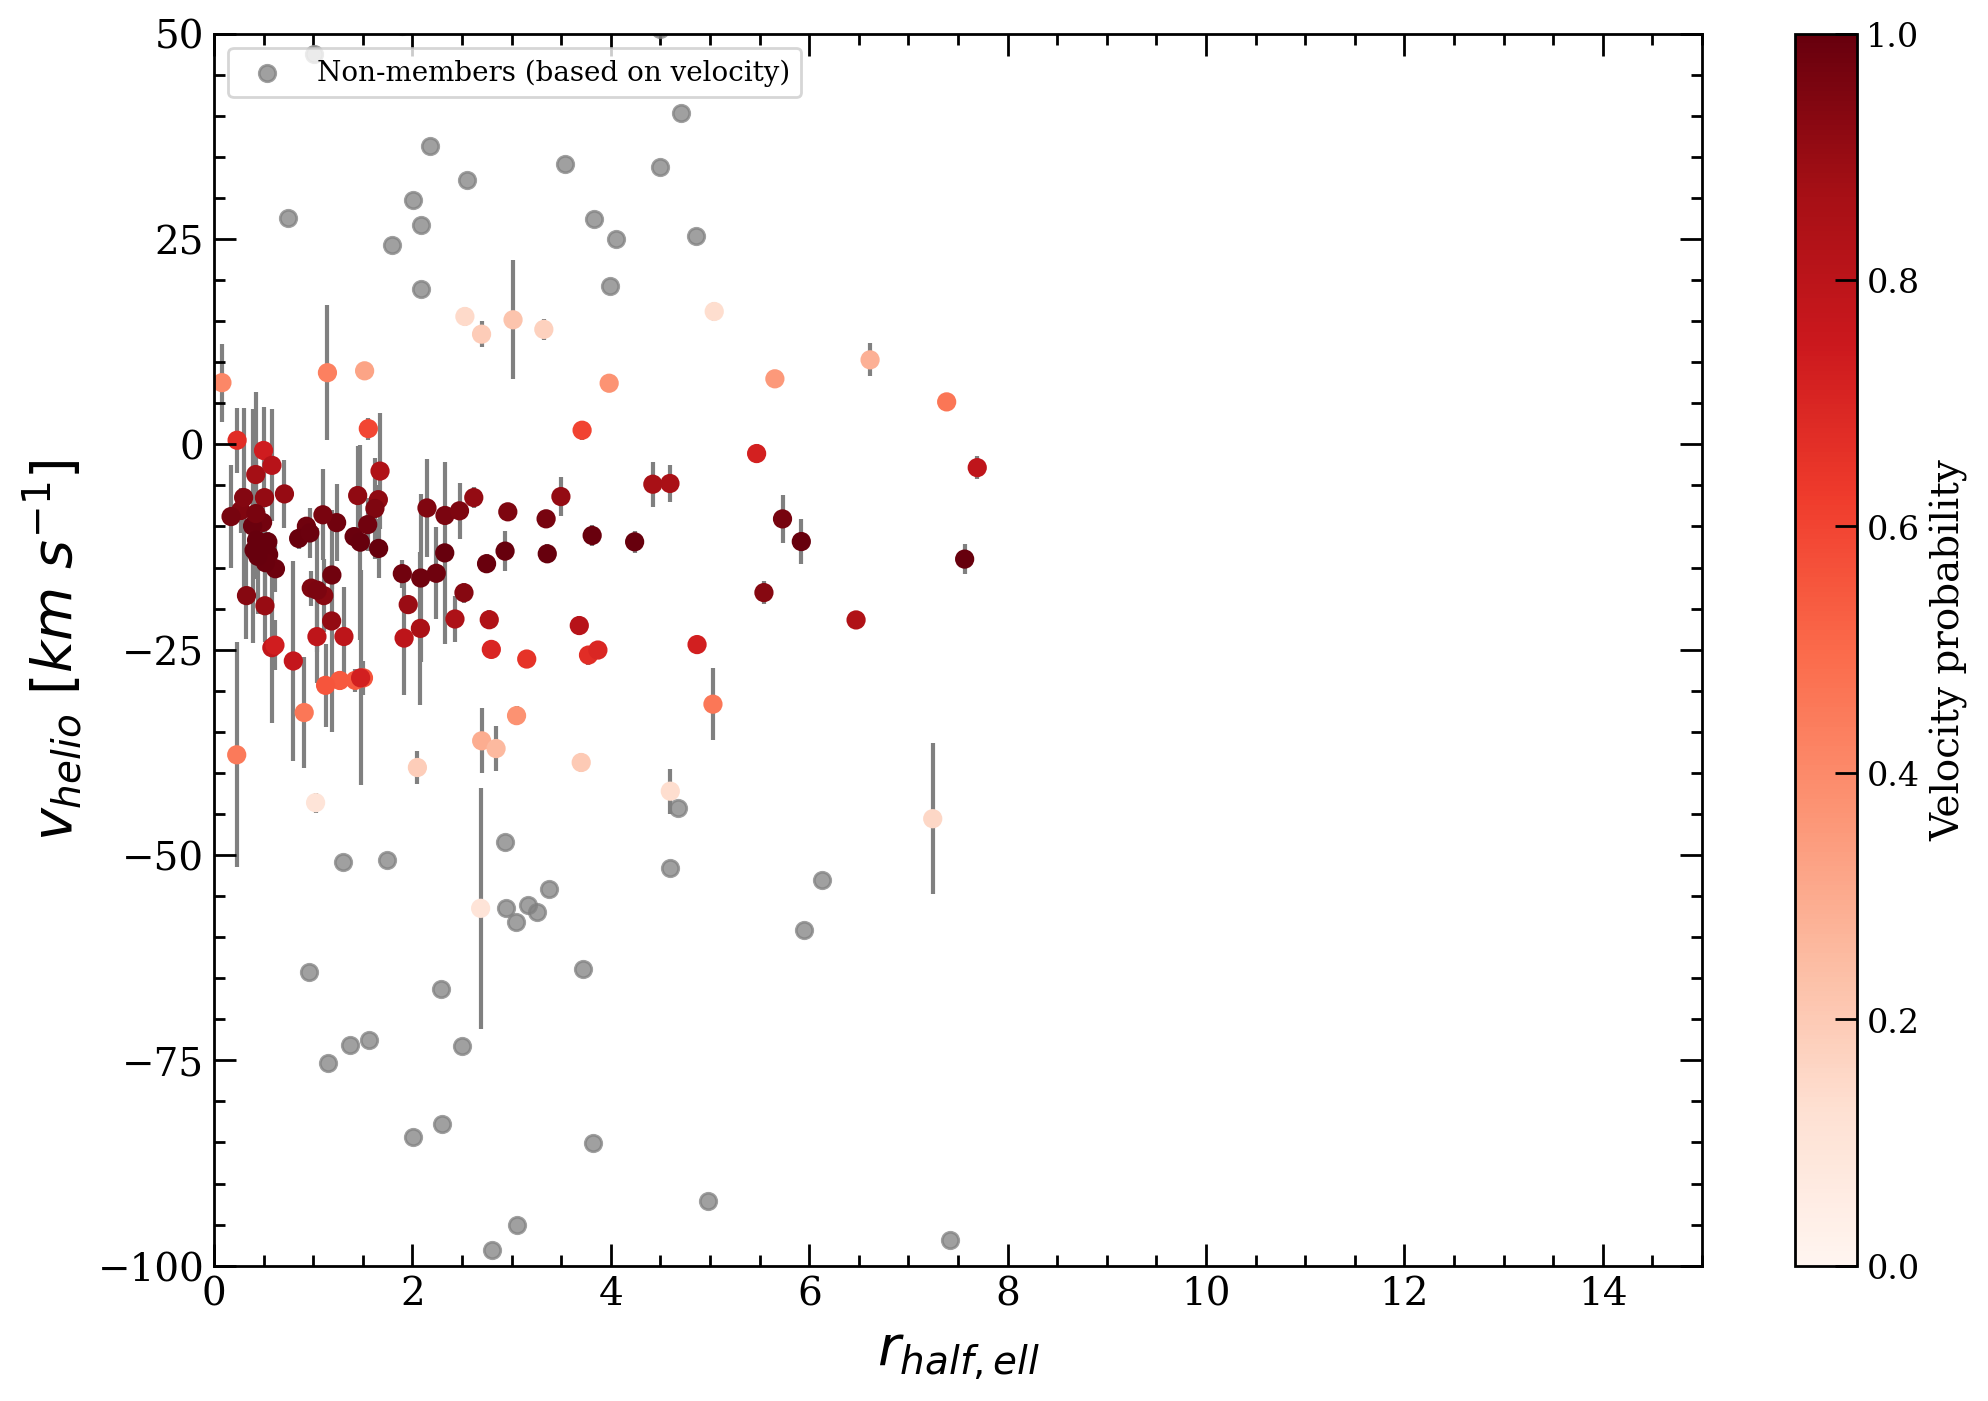

In [17]:
fig = plt.figure(figsize = (12, 8))
ax = fig.gca()

# deimos vel non-members
vel_nonmember = deimos_data[deimos_data["v_marker"] < 0.1]
ax.scatter(vel_nonmember["hl_radius_ell"], vel_nonmember["v"], c = "grey", alpha = 0.75,
           s = 35, zorder = 2, label = "Non-members (based on velocity)")

# deimos member data
vel_member = deimos_data[deimos_data["v_marker"] >= 0.1]
data = ax.scatter(vel_member["hl_radius_ell"], vel_member["v"], c = vel_member["v_marker"], 
                  cmap = "Reds", s = 35, vmin = 0, vmax = 1, zorder = 1)
ax.errorbar(vel_member["hl_radius_ell"], vel_member["v"], yerr = vel_member["v_err"], 
            c = "grey", fmt = "o", ms = 2, zorder = 0)

ax.set_xlabel("$r_{half, ell}$", labelpad = 5, size = 20).set_color('black')
ax.set_ylabel("$v_{helio}~[km~s^{-1}]$", labelpad = 5, size = 20).set_color('black')

ax.set_xticks(np.arange(0, 16, 2), minor = False)
ax.set_xticks(np.arange(0, 16, 0.5), minor = True)
ax.tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 14, color = "black", top = True)
ax.tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax.set_yticks(np.arange(-100, 75, 25), minor = False)
ax.set_yticks(np.arange(-100, 75, 5), minor = True)
ax.tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black", right = True)
ax.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

ax.set_xlim(0, 15)
ax.set_ylim(-100, 50)

ax.legend(loc = "upper left", fontsize = 10)

cbar = plt.colorbar(data, ax = ax, location = "right")
cbar.set_label("Velocity probability", fontsize = 14)

# fig.savefig("deimos_vel.pdf", dpi = 600, transparent = True)

## (3) Gaia Proper Motion

In [18]:
# previous proper motion estimate from Pace+2022
pmra_pace      = 0.255
pmra_err_pace  = np.sqrt(0.082**2 + 0.023**2) # add in systematic error
pmdec_pace     = -1.110
pmdec_err_pace = np.sqrt(0.093**2 + 0.023**2)

membership_utils.save_variable("pmra_pace", pmra_pace)
membership_utils.save_variable("pmra_err_pace", pmra_err_pace)
membership_utils.save_variable("pmdec_pace", pmdec_pace)
membership_utils.save_variable("pmdec_err_pace", pmdec_err_pace)

Define proper motion probability distribution:
$$
P_{\rm pm} = \exp \Bigl( -\frac{(\mu_\alpha \cos \delta, \mu_\delta - v_{W1})^2}{2 [ (3\sigma_{v, W1})^2 + \delta_v^2 ]} \Bigr)
$$

In [19]:
def pm_prob(pmra, pmra_err, pmdec, pmdec_err):
    pace_err = (pmra_err_pace ** 2 + pmdec_err_pace ** 2) ** (0.5)
    pm_err = (pmra_err ** 2 + pmdec_err ** 2) ** (0.5)
    p_pm = np.exp(-((pmra - pmra_pace) ** 2 + (pmdec - pmdec_pace) ** 2) / (2 * ((2 * pace_err) ** 2 + pm_err ** 2)))
    return p_pm

In [20]:
deimos_data["pm_marker"]   = np.nan       # proper motion marker
deimos_data["pm_err_flag"] = np.nan       # proper motion error flag (if S/N > 2 == treat as non-measurements)

# calculate P_pm for each star
for index_deimos, row_deimos in deimos_data.iterrows():
    if (row_deimos["gaia_pmra_err"] > 0):
        # pmra/pmdec + error data
        pmra_star = row_deimos["gaia_pmra"]
        pmdec_star = row_deimos["gaia_pmdec"]
        pmra_err_star = row_deimos["gaia_pmra_err"]
        pmdec_err_star = row_deimos["gaia_pmdec_err"]
        
        # error flag
        if ((pmra_err_star / pmra_star) > 2) | ((pmdec_err_star / pmdec_star) > 2):
            deimos_data.loc[index_deimos, "pm_err_flag"] = 1
        
        else:
            deimos_data.loc[index_deimos, "pm_err_flag"] = 0

            dist_pmra = abs(pmra_star - pmra_pace)
            dist_pmdec = abs(pmdec_star - pmdec_pace)
            
            # calculate marker
            if ((dist_pmra / pmra_err_star) < 3) & ((dist_pmdec / pmdec_err_star) < 3):
                deimos_data.loc[index_deimos, "pm_marker"] = pm_prob(pmra_star, pmra_err_star, pmdec_star, pmdec_err_star)
            
            else:
                deimos_data.loc[index_deimos, "pm_marker"] = 0
                deimos_data.loc[index_deimos, "prob_member"] = 0

Proper motion plot

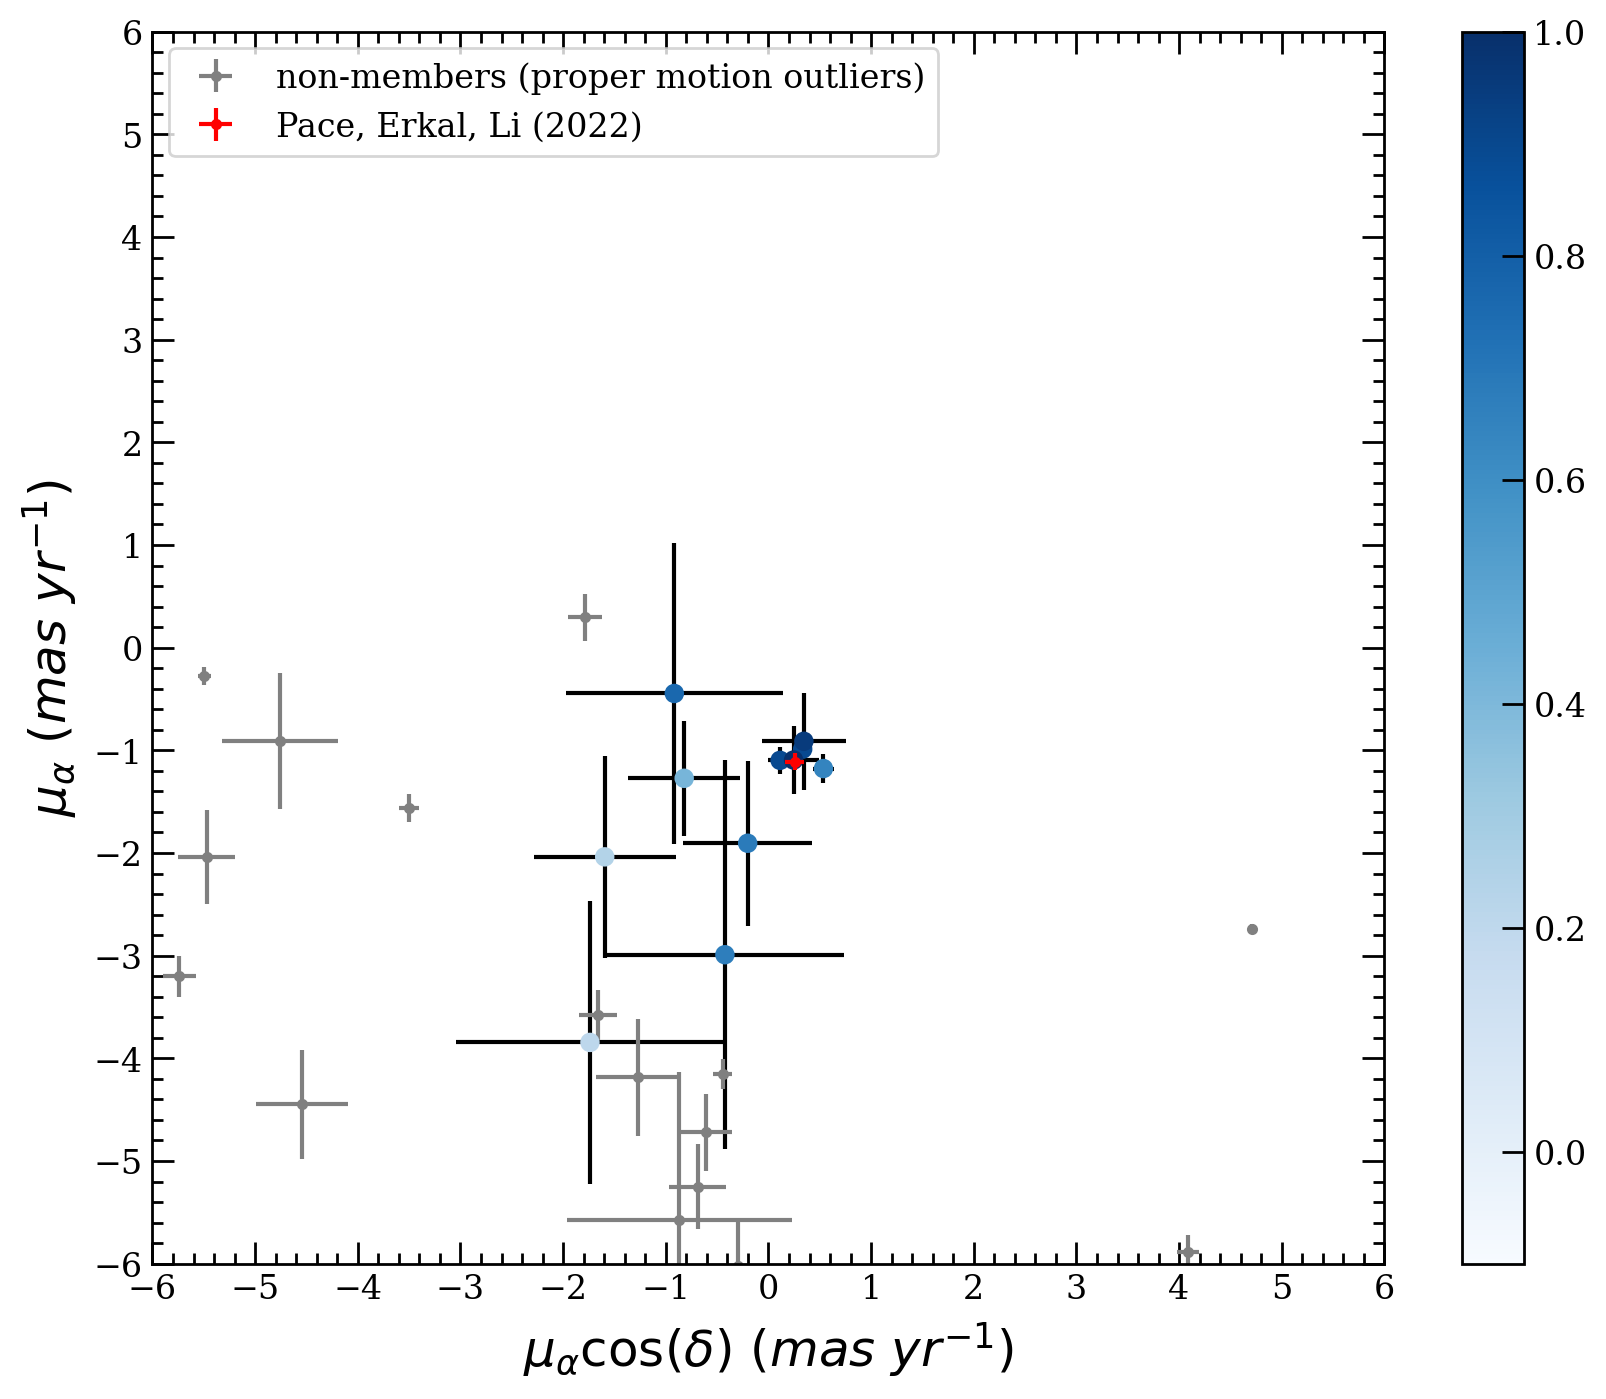

In [21]:
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
ax.set_aspect('equal', adjustable='box')

# gaia data
gaia_data = deimos_data[(deimos_data["gaia_pmra_err"] > 0)]

# deimos pm non-members
pm_nonmember = gaia_data[gaia_data["pm_marker"] < 0.1]
plt.errorbar(pm_nonmember["gaia_pmra"], pm_nonmember["gaia_pmdec"], yerr = pm_nonmember["gaia_pmdec_err"], xerr = pm_nonmember["gaia_pmra_err"], 
             ms = 3, fmt = "o", color = "grey", label = "non-members (proper motion outliers)")

# deimos member data
pm_member = gaia_data[gaia_data["pm_marker"] >= 0.1]
plt.errorbar(pm_member["gaia_pmra"], pm_member["gaia_pmdec"], yerr = pm_member["gaia_pmdec_err"], xerr = pm_member["gaia_pmra_err"], 
             fmt = "o", c = "black", ms = 3, zorder = 1)
data = ax.scatter(pm_member["gaia_pmra"], pm_member["gaia_pmdec"], c = pm_member["pm_marker"], cmap = "Blues", vmin = -0.1, vmax = 1, zorder = 2)

plt.errorbar(pmra_pace, pmdec_pace, yerr = pmra_err_pace, xerr = pmdec_err_pace, fmt = "o", c = "red", ms = 3, label = "Pace, Erkal, Li (2022)")

# circ = Circle((pmra_pace, pmdec_pace), 1, fill = False, edgecolor = "black")
# ax.add_patch(circ)

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

ax.set_xlabel(r'$\mu_{\alpha} \cos(\delta)~(mas~yr^{-1})$', labelpad = 5, size = 18).set_color('black')
ax.set_ylabel(r'$\mu {}_{\alpha} ~(mas~yr^{-1})$', labelpad = 5, size = 18).set_color('black')

ax.set_xticks(np.arange(-6, 7, 1), minor = False)
ax.set_xticks(np.arange(-6, 6.2, 0.2), minor = True)
ax.tick_params(which = "major", axis = "x", direction = "in", size = 8, color = "black", top = True)
ax.tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax.set_yticks(np.arange(-6, 7, 1), minor = False)
ax.set_yticks(np.arange(-6, 6.2, 0.2), minor = True)
ax.tick_params(which = "major", axis = "y", direction = "in", size = 8, color = "black", right = True)
ax.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

cbar = plt.colorbar(data)

ax.legend(loc = "upper left", fontsize = 12, frameon = True)

#fig.savefig("deimos_propermotion.pdf", dpi = 600, transparent = True)

## (4) Gaia parallax marker

Define parallax probability distribution:
$$
P_{\rm parallax} = 0 \text{~ if parallax-over-error > 3}
$$

$$
P_{\rm parallax} = 1 \text{~ if parallax-over-error < 3}
$$

In [22]:
deimos_data["parallax_marker"]   = np.nan       # parallax marker

# calculate P_parallax for each star
for index_deimos, row_deimos in deimos_data.iterrows():
    if (row_deimos["gaia_parallax_err"] > 0):
        # parallax + error data
        plx_star = row_deimos["gaia_parallax"]
        plx_err_star = row_deimos["gaia_parallax_err"]

        plx_over_err = abs(plx_star / plx_err_star)
        
        # calculate P_parallax
        if plx_over_err < 3:
            deimos_data.loc[index_deimos, "parallax_marker"] = 1
        
        else:
            deimos_data.loc[index_deimos, "parallax_marker"] = 0
            deimos_data.loc[index_deimos, "prob_member"] = 0

## (5) [Fe/H] marker

Define metallicity probability distribution:
$$
P_{\rm [Fe/H]} = \exp \Bigl( -\frac{(f - [Fe/H]_{W1})^2}{2 [ (2\sigma_{FeH})^2 + \delta_f^2 ]} \Bigr)
$$

In [23]:
def prob_metallicity(star_feh, star_feh_err, feh_avg, feh_disp):
    p_feh = np.exp(-((feh_avg - star_feh) ** 2) / (2 * ((2 * feh_disp) ** 2 + star_feh_err ** 2)))
    return p_feh

Determine $P_{FeH}$

In [24]:
deimos_data["feh_marker"] = np.nan      # empty marker

feh_avg = -2.1                          # [Fe/H] avg, disp from Willman+2011
feh_disp = 0.45

membership_utils.save_variable("feh_avg_2011", feh_avg)
membership_utils.save_variable("feh_disp_2011", feh_disp)

In [25]:
for index_deimos, row_deimos in deimos_data.iterrows():
    # FeH data
    ew_feh = row_deimos["ew_feh"]
    ew_feh_err = row_deimos["ew_feh_err"]
    
    if (ew_feh_err > 0) & (row_deimos["flag_HB"] == 0): # not HB star
        p_feh = prob_metallicity(ew_feh, ew_feh_err, feh_avg, feh_disp)
        deimos_data.loc[index_deimos, "feh_marker"] = p_feh

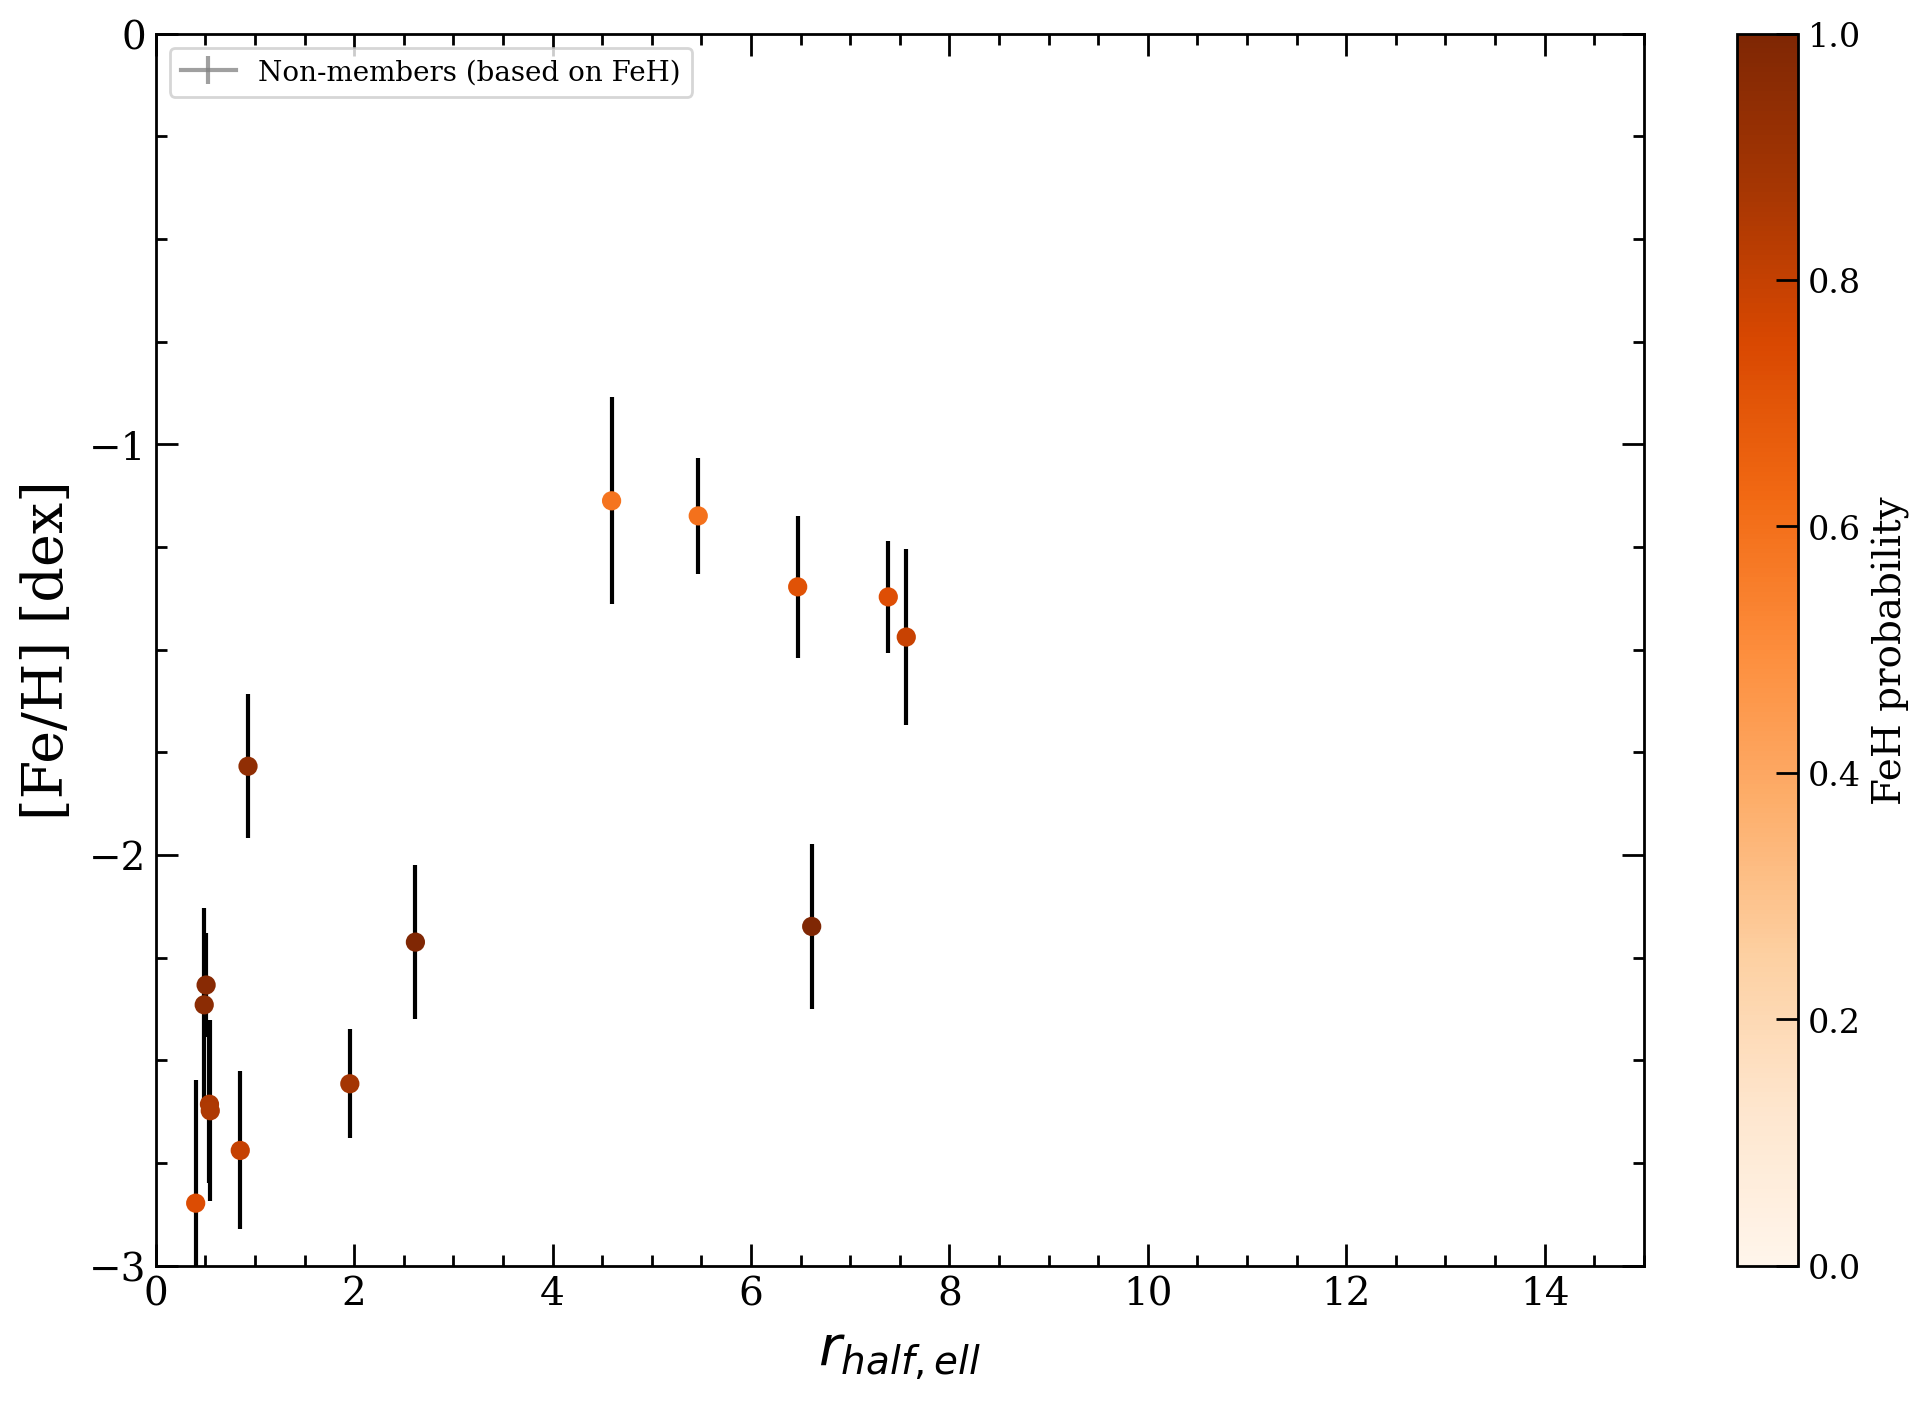

In [26]:
fig = plt.figure(figsize = (12, 8))
ax = fig.gca()

# deimos vel non-members
feh_nonmember = deimos_data[(deimos_data["feh_marker"] < 0.1) & (deimos_data["ew_feh_err"] > 0)]
ax.errorbar(feh_nonmember["hl_radius_ell"], feh_nonmember["ew_feh"], yerr = feh_nonmember["ew_feh_err"],
            c = "grey", alpha = 0.75, ms = 3, zorder = 2, label = "Non-members (based on FeH)")

# deimos member data
feh_member = deimos_data[deimos_data["feh_marker"] >= 0.1]
data = ax.scatter(feh_member["hl_radius_ell"], feh_member["ew_feh"], c = feh_member["feh_marker"], 
                  cmap = "Oranges", s = 35, vmin = 0, vmax = 1, zorder = 1)
ax.errorbar(feh_member["hl_radius_ell"], feh_member["ew_feh"], yerr = feh_member["ew_feh_err"], 
            c = "black", fmt = "o", ms = 2, zorder = 0)

ax.set_xlabel("$r_{half, ell}$", labelpad = 5, size = 20).set_color('black')
ax.set_ylabel("[Fe/H] [dex]", labelpad = 5, size = 20).set_color('black')

ax.set_xticks(np.arange(0, 16, 2), minor = False)
ax.set_xticks(np.arange(0, 16, 0.5), minor = True)
ax.tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 14, color = "black", top = True)
ax.tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax.set_yticks(np.arange(-3, 1, 1), minor = False)
ax.set_yticks(np.arange(-3, 0.25, 0.25), minor = True)
ax.tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 14, color = "black", right = True)
ax.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

ax.set_xlim(0, 15)
ax.set_ylim(-3, 0)

ax.legend(loc = "upper left", fontsize = 10)

cbar = plt.colorbar(data, ax = ax, location = "right")
cbar.set_label("FeH probability", fontsize = 14)

# fig.savefig("deimos_feh.pdf", dpi = 600, transparent = True)

## Member sample

$P_{mem} \propto P_{CMD} \times P_{parallax} \times P_{pm}  \times P_{vel}  \times P_{FeH}$

#### markers:
- spatial marker (not used for selection)
- cmd marker
- velocity marker (only exclusive probability)
- parallax marker
- proper motion marker
- metallicity marker (only exclusive probability)
- ew NaI marker / CaT + MgI (not used for selection)

#### non-members (hard cuts):
- $>0.6$ mag away from isochrone
- velocity $>100$ km/s or $<-100$ km/s, $v_{err} > 15$ km/s
- parallax over error $> 3$
- proper motion $> 3$ error bars away from predicted center
- extragalactic object

In [27]:
deimos_data["prob_member"] = np.nan
deimos_data["sample"] = 0

for index_deimos, row_deimos in deimos_data.iterrows():
    cmd = row_deimos["cmd_marker"]
    v = row_deimos["v_marker"]

    parallax = row_deimos["parallax_marker"]
    if np.isnan(parallax):
        parallax = 1

    pm = row_deimos["pm_marker"]
    if np.isnan(pm):
        pm = 1

    feh = row_deimos["feh_marker"]
    if np.isnan(feh):
        feh = 1

    # calculate membership probability
    p_mem = cmd * v * parallax * pm * feh
    p_nov = cmd * parallax * pm * feh
    p_nomet = cmd * v * parallax * pm

    # manually add in blue straggler (Pmem lowered due to CMD)
    if index_deimos == bs_index:
        p_mem = 0.5
        p_nov = 0.5
        p_nomet = 0.5

    deimos_data.loc[index_deimos, "prob_member"] = p_mem
    deimos_data.loc[index_deimos, "prob_nov"] = p_nov
    deimos_data.loc[index_deimos, "prob_nomet"] = p_nomet

    if p_mem >= 0.5:
        deimos_data.loc[index_deimos, "sample"] = 1

In [28]:
deimos_data.to_csv("data/dmost_cutdata_evaluated.csv")

In [29]:
# combine with full deimos data to one df and save
new_cols = deimos_data.columns.difference(deimos_full.columns)
deimos_combine = deimos_full.merge(deimos_data[new_cols], left_index = True, right_index = True, how = 'left')
deimos_combine.to_csv("data/dmost_alldata_evaluated.csv")

## NaI and MgI absorption lines

In [30]:
non_mems = deimos_data[(deimos_data["sample"] == 0) & (deimos_data["ew_naI_err"] > 0)]
samp     = deimos_data[(deimos_data["sample"] == 1) & (deimos_data["ew_naI_err"] > 0)]

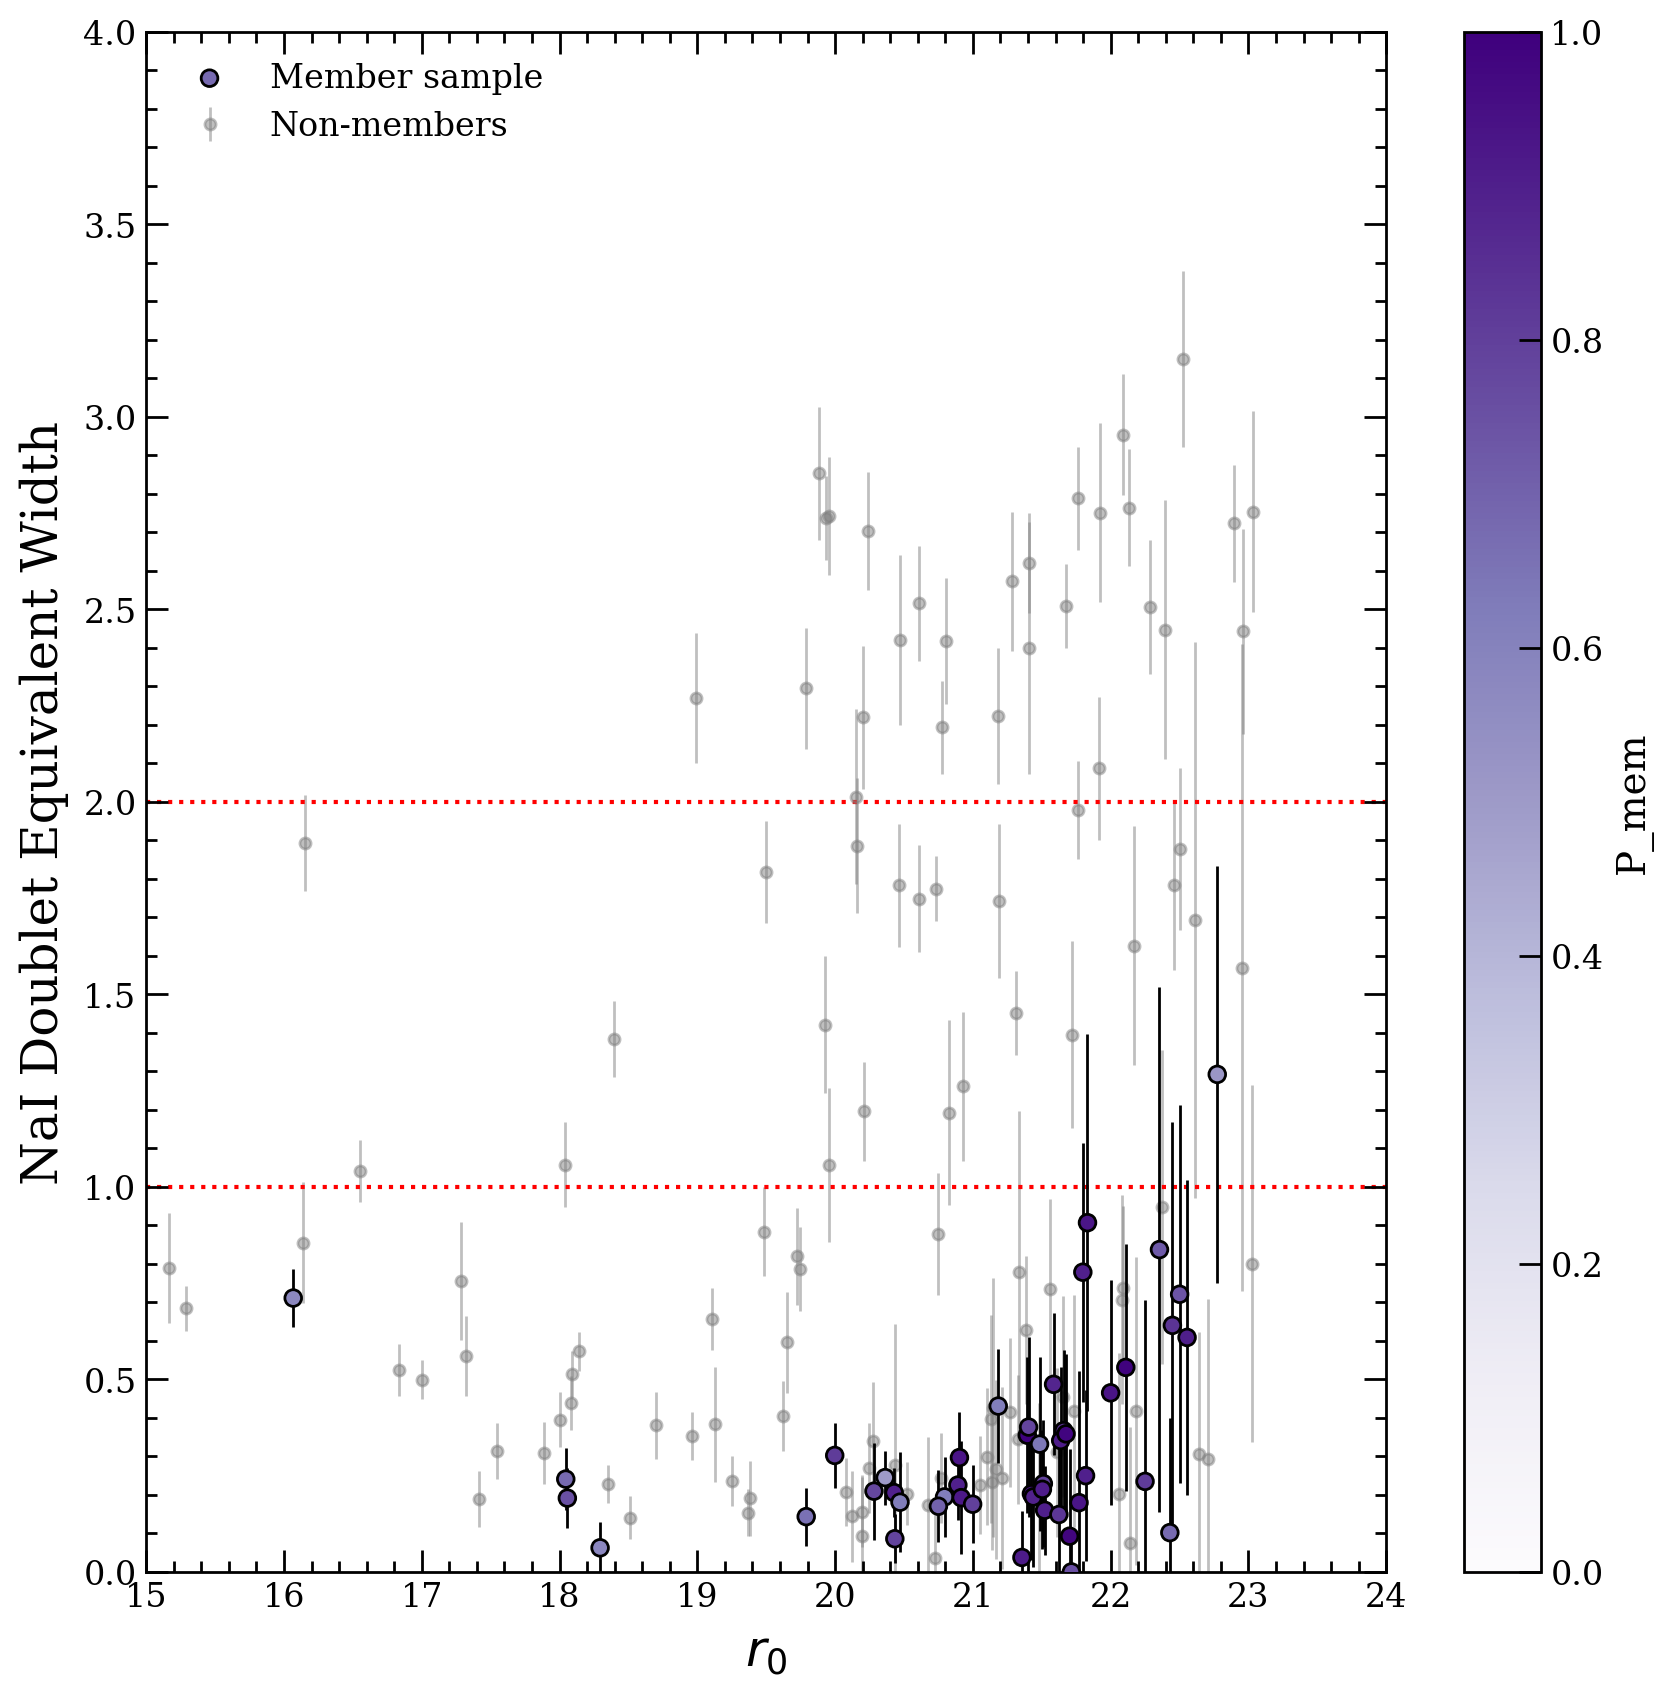

In [31]:
fig = plt.figure(figsize = (10, 10))
ax = fig.gca()

ax.errorbar(non_mems["rmag_o"], non_mems["ew_naI"], yerr = non_mems["ew_naI_err"], 
            fmt = "o", c = "grey", alpha = 0.5, elinewidth = 1, ms = 4, zorder = 0, label = "Non-members")
ax.errorbar(samp["rmag_o"], samp["ew_naI"], yerr = samp["ew_naI_err"], 
            fmt = "o", color = "thistle", ecolor = "black", elinewidth = 1, ms = 4, zorder = 1)
d = ax.scatter(samp["rmag_o"], samp["ew_naI"], c = samp["prob_member"], 
           cmap = "Purples", edgecolor = "black", vmin = 0, vmax = 1, s = 36, zorder = 3, label = "Member sample")

# cutoff lines
ax.axhline(y = 1, linestyle = ':', color = 'red', zorder = 0)
ax.axhline(y = 2, linestyle = ':', color = 'red', zorder = 0)

ax.set_xlim(15, 24)
ax.set_ylim(0, 4)

ax.set_xlabel("$r_0$", labelpad = 5, size = 18).set_color('black')
ax.set_ylabel("NaI Doublet Equivalent Width", labelpad = 5, size = 18).set_color('black')

ax.set_xticks(np.arange(15, 25, 1), minor = False)
ax.set_xticks(np.arange(15, 24.2, 0.2), minor = True)
ax.tick_params(which = "major", axis = "x", direction = "in", size = 8, color = "black", top = True)
ax.tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax.set_yticks(np.arange(0, 4.5, 0.5), minor = False)
ax.set_yticks(np.arange(0, 4.1, 0.1), minor = True)
ax.tick_params(which = "major", axis = "y", direction = "in", size = 8, color = "black", right = True)
ax.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

cbar = plt.colorbar(d)
cbar.set_label("P_mem", fontsize = 14)

ax.legend(loc = 'upper left', fontsize = 12, frameon = False)

# fig.savefig("deimos_NaI.pdf", dpi = 600, transparent = True)

In [32]:
large_naI = ((deimos_data["prob_member"] > 0.5) & 
             (deimos_data["ew_naI"] > 0) & 
             (abs(deimos_data["ew_naI"] - deimos_data["ew_naI_err"]) > 1))
print(f"Potential members (P_mem > 0.5) with NaI > 1: {np.sum(large_naI)}")

Potential members (P_mem > 0.5) with NaI > 1: 0


In [33]:
non_mems = deimos_data[(deimos_data["sample"] == 0) & (deimos_data["ew_mgI_err"] > 0)]
samp     = deimos_data[(deimos_data["sample"] == 1) & (deimos_data["ew_mgI_err"] > 0)]

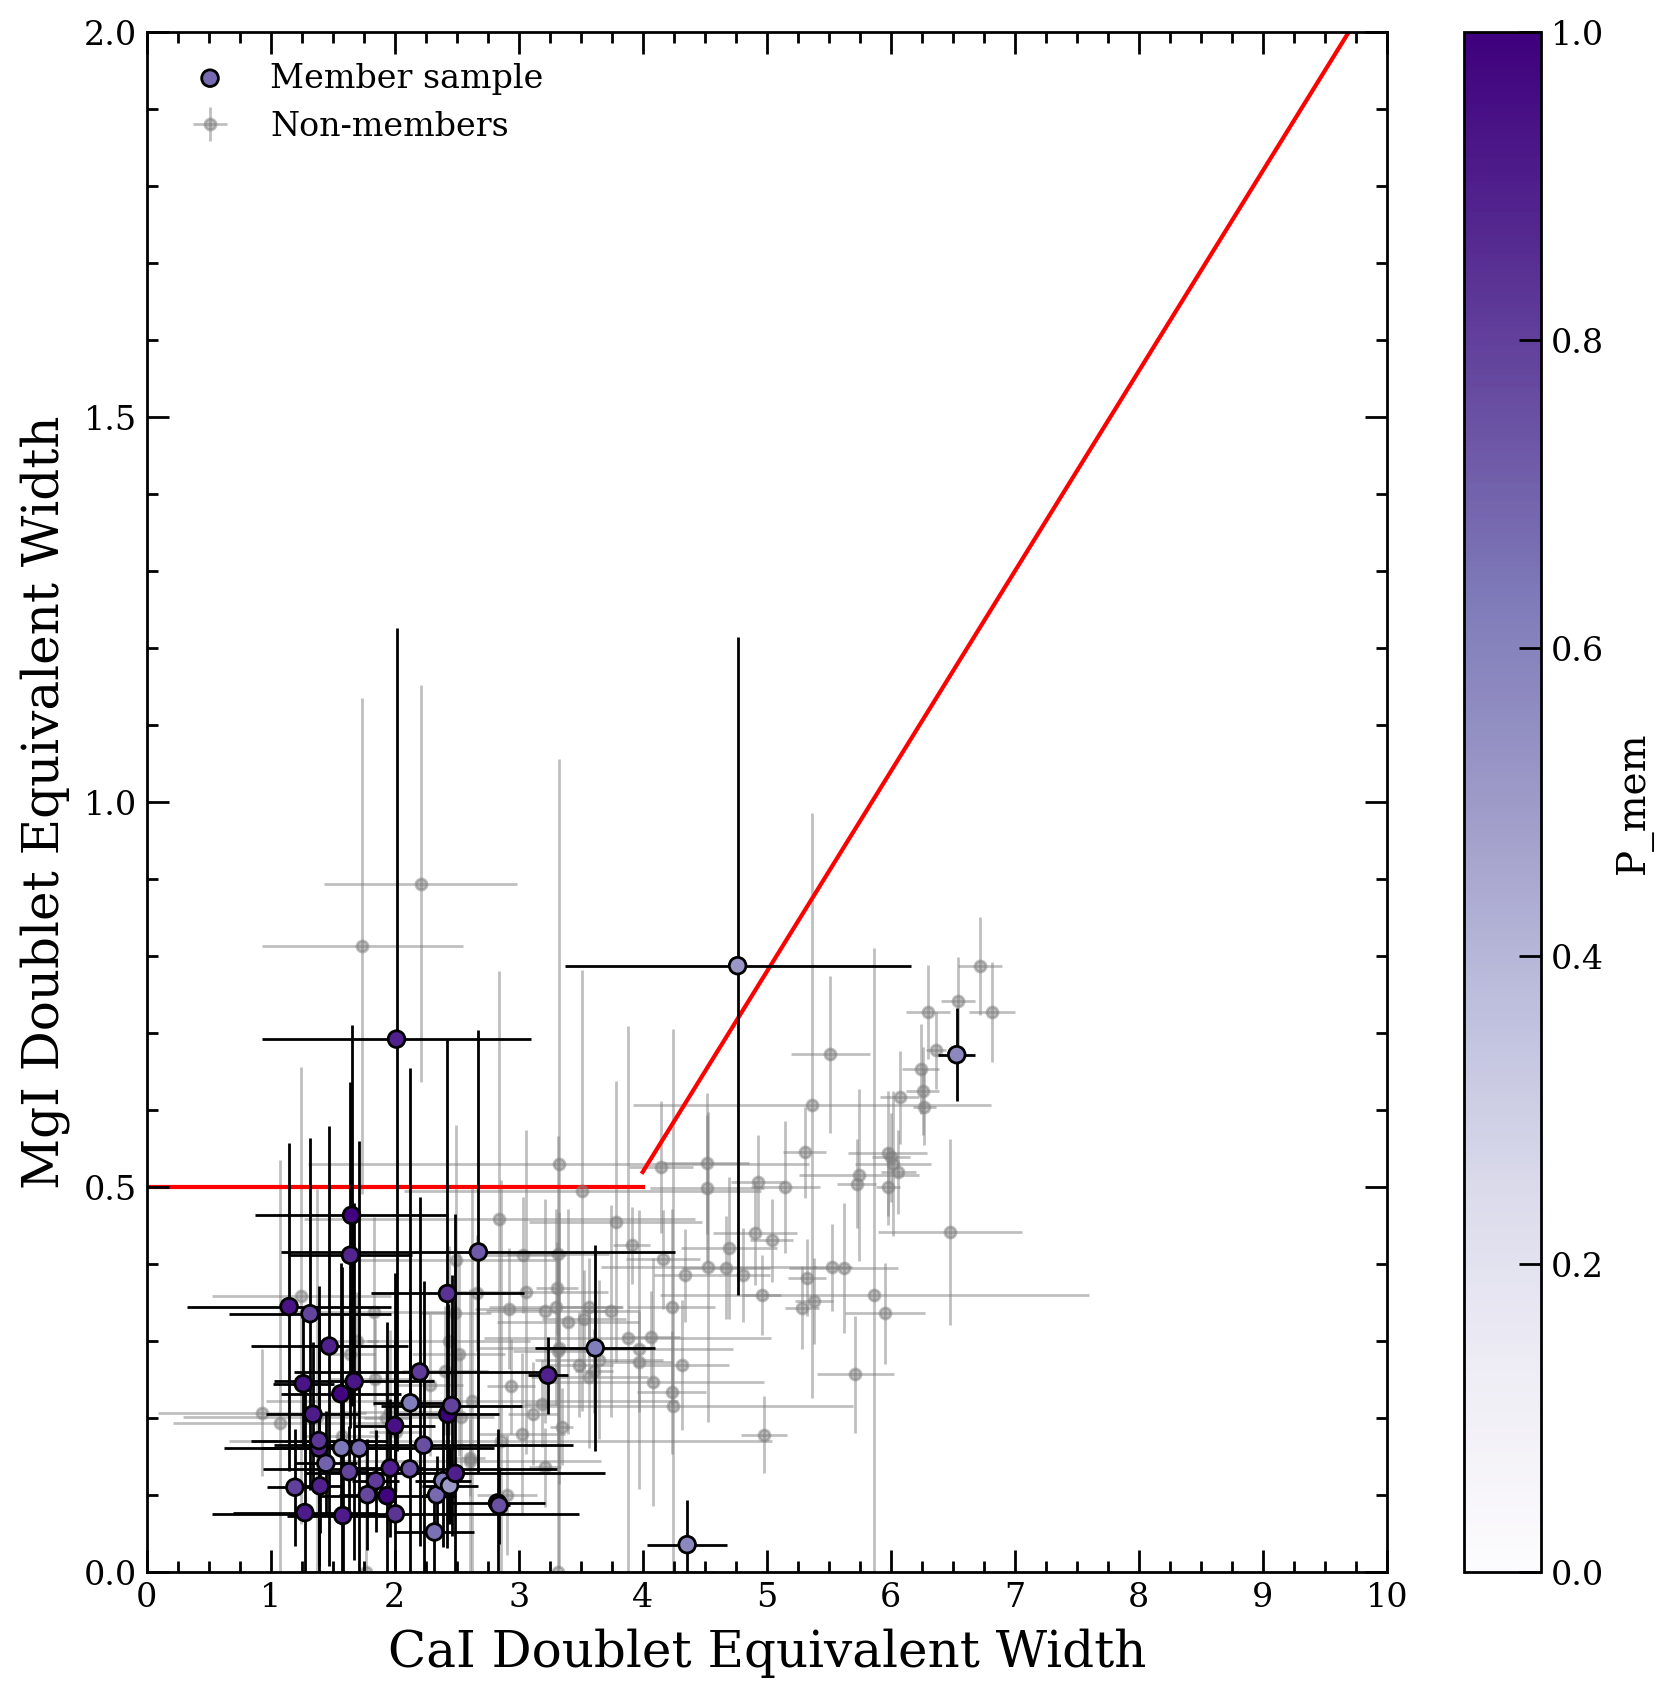

In [34]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()

non_mems_cat_err = non_mems["ew_cat_err"] * (abs(non_mems["ew_cat_err"]) < 10)
samp_cat_err  = samp["ew_cat_err"] * (abs(samp["ew_cat_err"]) < 10)

ax.errorbar(non_mems["ew_cat"], non_mems["ew_mgI"], yerr = non_mems["ew_mgI_err"], xerr = non_mems_cat_err, 
            fmt = "o", c = "grey", alpha = 0.5, elinewidth = 1, ms = 4, zorder = 0, label = "Non-members")
ax.errorbar(samp["ew_cat"], samp["ew_mgI"], yerr = samp["ew_mgI_err"], xerr = samp_cat_err, 
            fmt = "o", ecolor = "black", elinewidth = 1, ms = 2, zorder = 1)
d = ax.scatter(samp["ew_cat"], samp["ew_mgI"], c = samp["prob_member"], 
           cmap = "Purples", edgecolor = "black", vmin = 0, vmax = 1, s = 36, zorder = 3, label = "Member sample")

# cutoff lines
ax.axhline(0.5, xmin = 0, xmax = 0.4, c = "red", zorder = 0)
ax.plot(np.linspace(4, 11, 10), 0.26 * np.linspace(4, 11, 10) - 0.5206, c = "red", zorder = 0)

ax.set_xlim(0, 10)
ax.set_ylim(0, 2)

ax.set_xlabel("CaI Doublet Equivalent Width", labelpad = 5, size = 18).set_color('black')
ax.set_ylabel("MgI Doublet Equivalent Width", labelpad = 5, size = 18).set_color('black')

ax.set_xticks(np.arange(0, 12, 1), minor = False)
ax.set_xticks(np.arange(0, 12, 0.25), minor = True)
ax.tick_params(which = "major", axis = "x", direction = "in", size = 8, color = "black", top = True)
ax.tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax.set_yticks(np.arange(0, 4.5, 0.5), minor = False)
ax.set_yticks(np.arange(0, 4.1, 0.1), minor = True)
ax.tick_params(which = "major", axis = "y", direction = "in", size = 8, color = "black", right = True)
ax.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

cbar = plt.colorbar(d)
cbar.set_label("P_mem", fontsize = 14)

ax.set_xlim(0, 10)
ax.set_ylim(0, 2)

ax.legend(loc = 'upper left', fontsize = 12, frameon = False)

# fig.savefig("deimos_mg_cat.pdf", dpi = 600, transparent = True)

In [35]:
a = ((deimos_data["prob_member"] > 0.5) & (deimos_data["ew_mgI"] > 0) & (deimos_data["ew_cat"] > 0))

above_cut1 = ((deimos_data["ew_cat"] < 4) & 
              ((deimos_data["ew_mgI"] - deimos_data["ew_mgI_err"]) > 0.5))

above_cut2 = ((deimos_data["ew_cat"] > 4) &
              (0.26 * abs(deimos_data["ew_mgI"] - deimos_data["ew_mgI_err"]) > 0.5206))

print(f"Potential members (P_mem > 0.5) above MgI/CaI cut: {np.sum(a * above_cut1) + np.sum(a * above_cut2)}")

Potential members (P_mem > 0.5) above MgI/CaI cut: 0
